In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from subprocess import check_call

from datetime import datetime
from pathlib import Path

import roms_tools as rt

import config
import source_data
import util

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Define the grid

Specify the grid name and parameters defining its geometry and MPI domain decomposition.

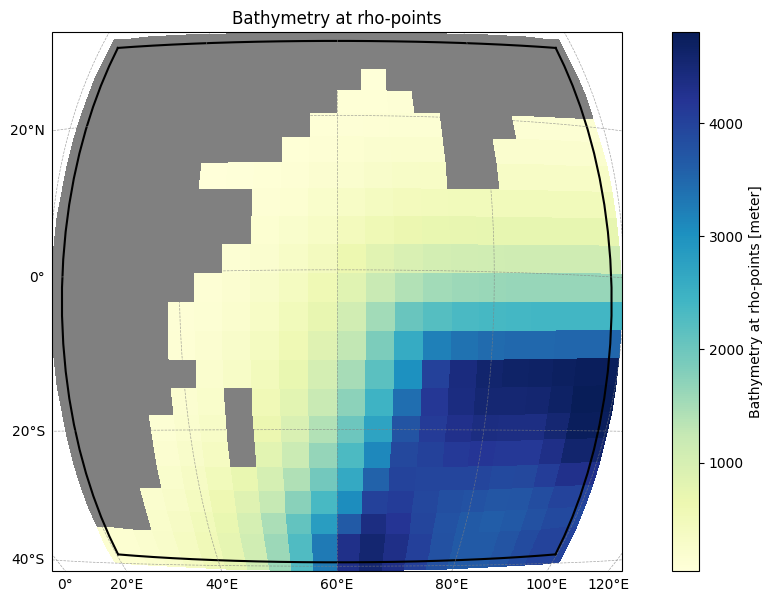

In [3]:
grid_name = "wio-toy"

start_time = datetime(2012, 1, 1)
end_time = datetime(2012, 2, 1)

boundaries={
        "south": True,
        "east": True,
        "north": True,
        "west": True, 
    }
np_eta = 5 # number of partitions in eta (y) 
np_xi = 2 # number of partitions in xi (x) 

grid = rt.Grid(
    nx=20,           # number of grid points in x-direction
    ny=20,           # number of grid points in y-direction
    size_x=8000,       # domain size in x-direction (km)
    size_y=8000,       # domain size in y-direction (km)
    center_lon=60.0,    # center longitude (E)
    center_lat=-4.0,    # center latitude (S)
    rot=0,            # no rotation
    N=10,             # number of vertical layers
)
grid.plot()

## Stage source data

Ensure that source data assets are available locally.

In [4]:
%%time
source_data = source_data.SourceData(
    grid_name=grid_name,
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    datasets=["GLORYS", "unified_bgc"],
    clobber=False,
).prepare_all()

✔️  Using existing GLORYS file: /Users/mclong/data/source_data/GLORYS_wio-toy_2012-01-01-2012-02-01.nc
✔️  Using existing BGC dataset: /Users/mclong/data/source_data/BGCdataset.nc
CPU times: user 345 μs, sys: 322 μs, total: 667 μs
Wall time: 432 μs


## Preprocess model input files

Generate all the files that the model reads at runtime.

In [6]:
%%time
# TODO: add CDR forcing
roms_in = util.gen_inputs(
    grid_name=grid_name,
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    np_eta=np_eta,
    np_xi=np_xi,
    boundaries=boundaries,
    source_data=source_data,
    clobber=True,
)
roms_in

2025-11-13 15:27:33 - INFO - Writing the following NetCDF files:
/Users/mclong/data/input_data/wio-toy/roms_grd.nc
2025-11-13 15:27:33 - INFO - Sea surface height will NOT be used to adjust depth coordinates.


⚠️  Clobber=True: removing 9 existing .nc files...

▶️  [1/9] Writing ROMS grid...
▶️  [2/9] Generating initial conditions...


2025-11-13 15:27:39 - INFO - Writing the following NetCDF files:
/Users/mclong/data/input_data/wio-toy/roms_ic.nc


[########################################] | 100% Completed | 23.51 ss


2025-11-13 15:28:02 - INFO - No path specified for ERA5 source; defaulting to ARCO ERA5 dataset on Google Cloud.


▶️  [3/9] Generating surface forcing (physics)...


2025-11-13 15:29:29 - INFO - Data will be interpolated onto the fine grid. Remember to set `interp_frc = 0` in your `bulk_frc.opt` ROMS option file.
2025-11-13 15:29:43 - INFO - Writing the following NetCDF files:
/Users/mclong/data/input_data/wio-toy/roms_frc_201201.nc
/Users/mclong/data/input_data/wio-toy/roms_frc_201202.nc


[########################################] | 100% Completed | 264.46 s
[########################################] | 100% Completed | 835.85 ms


2025-11-13 15:34:22 - INFO - Data will be interpolated onto the fine grid. Remember to set `interp_frc = 0` in your `bgc.opt` ROMS option file.


▶️  [4/9] Generating surface forcing (BGC)...


2025-11-13 15:34:22 - INFO - Writing the following NetCDF files:
/Users/mclong/data/input_data/wio-toy/roms_frc_bgc_clim.nc


[########################################] | 100% Completed | 109.76 ms


2025-11-13 15:34:22 - INFO - Sea surface height will NOT be used to adjust depth coordinates.


▶️  [5/9] Generating boundary forcing (physics)...


2025-11-13 15:34:29 - INFO - Writing the following NetCDF files:
/Users/mclong/data/input_data/wio-toy/roms_bry_201201.nc
/Users/mclong/data/input_data/wio-toy/roms_bry_201202.nc


[########################################] | 100% Completed | 34.93 s
[########################################] | 100% Completed | 668.87 ms


2025-11-13 15:35:06 - INFO - Sea surface height will NOT be used to adjust depth coordinates.


▶️  [6/9] Generating boundary forcing (BGC)...


2025-11-13 15:35:08 - INFO - Writing the following NetCDF files:
/Users/mclong/data/input_data/wio-toy/roms_bry_bgc_clim.nc


[########################################] | 100% Completed | 10.64 s
▶️  [7/9] Generating river forcing...


2025-11-13 15:35:19 - INFO - No river indices provided. Identify all rivers within the ROMS domain and assign each of them to the nearest coastal point.
2025-11-13 15:35:19 - INFO - Compute climatology for river forcing.
2025-11-13 15:35:19 - INFO - Creating 14 synthetic river(s) to handle overlapping entries.
2025-11-13 15:35:20 - WARNING - NaNs detected in 'river_volume' and set to zero. This may indicate missing river data and affect model accuracy. 
2025-11-13 15:35:20 - INFO - Writing the following NetCDF files:
/Users/mclong/data/input_data/wio-toy/roms_rivers.nc


▶️  [8/9] Generating CDR forcing...

📦  [9/9] Partitioning input files across tiles...
✅ All input files generated and partitioned.

CPU times: user 5min 54s, sys: 2min 57s, total: 8min 51s
Wall time: 7min 48s


ROMSInputs(grid_name='wio-toy', grid=Grid(nx=20, ny=20, size_x=8000, size_y=8000, center_lon=60.0, center_lat=-4.0, rot=0, N=10, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source={'name': 'ETOPO5'}, hmin=5.0, verbose=False, straddle=False), start_time=datetime.datetime(2012, 1, 1, 0, 0), end_time=datetime.datetime(2012, 2, 1, 0, 0), np_eta=5, np_xi=2, boundaries={'south': True, 'east': True, 'north': True, 'west': True}, source_data=SourceData(grid=Grid(nx=20, ny=20, size_x=8000, size_y=8000, center_lon=60.0, center_lat=-4.0, rot=0, N=10, theta_s=5.0, theta_b=2.0, hc=300.0, topography_source={'name': 'ETOPO5'}, hmin=5.0, verbose=False, straddle=False), grid_name='wio-toy', start_time=datetime.datetime(2012, 1, 1, 0, 0), end_time=datetime.datetime(2012, 2, 1, 0, 0), datasets=['GLORYS', 'UNIFIED_BGC'], clobber=False), use_dask=True, clobber=True, input_data_dir=PosixPath('/Users/mclong/data/input_data/wio-toy'), grid_yaml=PosixPath('/Users/mclong/codes/cson-forge/workflows/blueprints

### Quick look at some forcing

[########################################] | 100% Completed | 7.00 sms


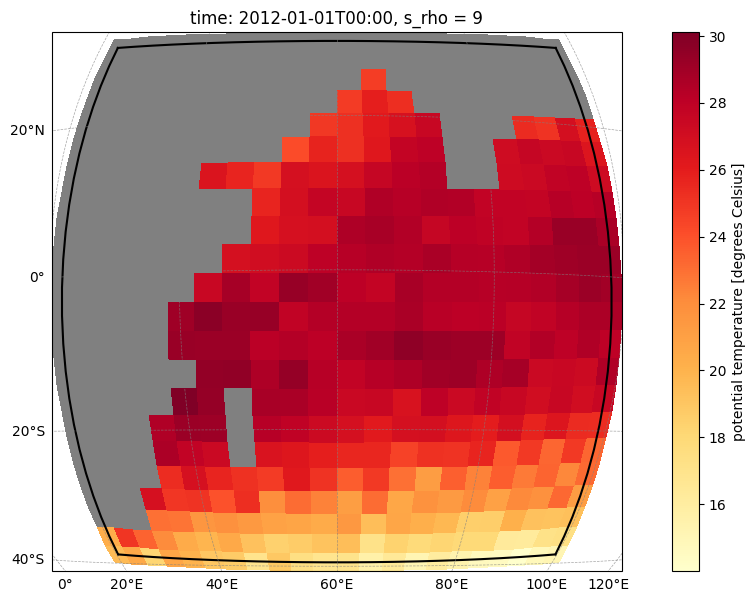

In [7]:
roms_in.ic.plot("temp", s=-1)

[########################################] | 100% Completed | 739.74 ms


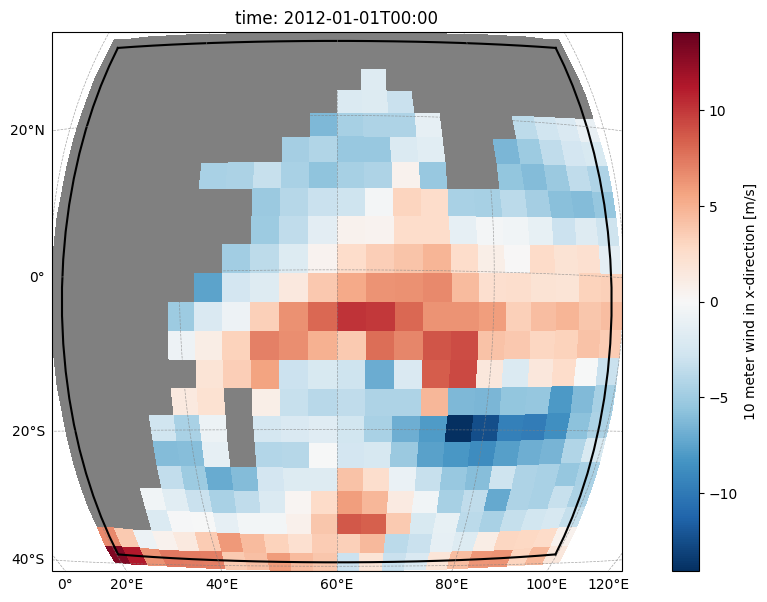

In [8]:
roms_in.frc.plot("uwnd", time=0)

## Build the model

Apply templating to source code and input files, then build the model

In [11]:
# apply templating engine to replace vars
parameters = {
    "param.opt": dict(NP_XI=np_xi, NP_ETA=np_eta),
    "river_frc.opt": dict(nriv=roms_in.rivers.ds.sizes["nriver"]),
    "roms.in": dict(), # TODO: build from roms_in
    "cdr_frc.opt": dict(), # TODO: build from roms_in
}

util.render_source(parameters)

err = check_call(["./build.roms-marbl.sh", "--grid-name", grid_name]) #, "--clean"])

Rendered files:
  - /Users/mclong/codes/cson-forge/workflows/model-configs/roms-marbl-cson-default/rendered/param.opt
  - /Users/mclong/codes/cson-forge/workflows/model-configs/roms-marbl-cson-default/rendered/river_frc.opt
  - /Users/mclong/codes/cson-forge/workflows/model-configs/roms-marbl-cson-default/rendered/roms.in
  - /Users/mclong/codes/cson-forge/workflows/model-configs/roms-marbl-cson-default/rendered/cdr_frc.opt


HEAD is now at 6e6b2f7 Merge branch 'add_abio' into development


[Build MARBL (compiler: gnu)] starting...
[Build MARBL (compiler: gnu)] OK
[Build NHMG/src] starting...
[Build NHMG/src] OK
[Build Tools-Roms] starting...
[Build Tools-Roms] OK
[Build ROMS (/Users/mclong/codes/cson-forge/workflows/model-configs/roms-marbl-cson-default)] starting...
[Build ROMS (/Users/mclong/codes/cson-forge/workflows/model-configs/roms-marbl-cson-default)] OK

✅ All builds completed.
• ROMS root:        /Users/mclong/codes/ucla-roms
• MARBL root:       /Users/mclong/codes/MARBL
• App root:         /Users/mclong/codes/cson-forge/workflows/model-configs/roms-marbl-cson-default
• Logs:             /Users/mclong/codes/cson-forge/workflows/logs

To run your case:
  cd "/Users/mclong/codes/cson-forge/workflows/model-configs/roms-marbl-cson-default"
  mpirun -n 6 ./roms <your_input>.in
